## Imports

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import math

## Dataset -> Dataframes

In [26]:

#ipeds_allIL_path = "../datasets/illinois/ipeds/ipedsallIL.csv"

#df_ipeds_allIL_colleges = pd.read_csv(IPEDS_allIL_path)


IL_nyt_colleges_path = "../datasets/illinois/IL_nyt_colleges.csv"
ipeds_path = "../datasets/illinois/ipeds/ipeds.csv"

df_nyt_IL_colleges = pd.read_csv(IL_nyt_colleges_path)
df_ipeds = pd.read_csv(ipeds_path)

## EDA


Cases per Capita

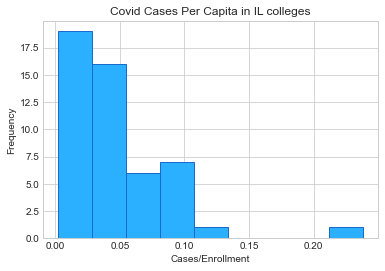

In [69]:
df_case_percapita = pd.DataFrame()

#categories I think will be useful for EDA here
df_case_percapita['cases'] = df_nyt_IL_colleges["cases"]
df_case_percapita['Enrollment'] = df_ipeds["Enrollment"]
df_case_percapita['Degree of urbanization'] = df_ipeds["Degree of urbanization"]
df_case_percapita['college']= df_nyt_IL_colleges["college"]
df_case_percapita['cases per capita']=df_case_percapita["cases"]/df_case_percapita["Enrollment"]

case_percapita = df_case_percapita['cases per capita']
case_percapita = case_percapita.dropna()


#chose bin size with Freedman-Diaconis rule: (max-min) / 2*IQR*n^(-1/3)
bin_size = (case_percapita.max()-case_percapita.min())/(2*st.iqr(case_percapita)*len(case_percapita)**(-1/3))
bin_size = math.ceil(bin_size)

plt.style.use('seaborn-whitegrid')
plt.hist(df_case_percapita['cases per capita'],bins=bin_size,facecolor='#2ab0ff',edgecolor="#196acf")
plt.title("Covid Cases Per Capita in IL colleges")
plt.ylabel("Frequency")
plt.xlabel("Cases/Enrollment")

plt.show()


